In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
torch.manual_seed(4)
np.random.seed(4)

In [2]:
BATCH_SIZE = 128
NUM_ITERS = int(2e4)
CRITERION = nn.CrossEntropyLoss()  


In [37]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,  transform=transform)


train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                        shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                        shuffle=False, num_workers=2)

EPOCHS = int(NUM_ITERS / (len(trainset) / BATCH_SIZE))

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

classes = ('plane', 'car', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(DEVICE)

Files already downloaded and verified
Files already downloaded and verified
cuda


In [4]:

# Block

class ResidualBlock(nn.Module):

    def __init__(self, stride=1, padding=1, batch_norm=False):
        super().__init__()
        self.batch_norm = batch_norm
        
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=stride, padding=padding)

        if batch_norm:
            self.bn1 = nn.BatchNorm2d(8)

        self.relu1 = nn.ReLU()        

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=stride, padding=padding)

        if batch_norm:
            self.bn2 = nn.BatchNorm2d(8)

        self.relu2 = nn.ReLU()       

         


    def forward(self, x):

        out = self.conv1(x)

        if self.batch_norm:
            out = self.bn1(out)

        out = self.relu1(out)

        out = self.conv2(x)

        if self.batch_norm:
            out = self.bn2(out)

        out = self.relu2(out + x)

        return out

# Model
class CNNModel(nn.Module):
    def __init__(self, batch_norm=False, N=10):

        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=0)
        # Size: 28 x 28

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, stride=2, padding=0)
        # Size: 12 x 12

        # Dynamic block num
        self.blocks = nn.Sequential(*[ResidualBlock(batch_norm=batch_norm) for _ in range(N)])
        # Size: 12 x 12

        self.conv3 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=2, padding=0)                    
        # Size: 5 X 5

        self.fc1 = nn.Linear(5 * 5 * 4, 100, bias=True) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 10, bias=False) 


    def forward(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        
        out = self.blocks(out)         # How is the shape the same after this???
        out = self.conv3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)

        return out

In [5]:

def calc_accuracy(model, train=False): # add train param to calculate accuracy on both train and test
    # Calculate Accuracy         
    correct = 0
    total = 0
    
    d_loader = train_loader if train else test_loader
    # Iterate through test dataset
    for images, labels in d_loader:
        # Load images
        images, labels = images.to(DEVICE), labels.to(DEVICE)        

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

    return 100 * correct / total

def train(model): 
    print(f'Training for {EPOCHS} epochs')
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)  
    accuracy = {'train': [], 'test': []}

    for epoch in range(EPOCHS):    
        for i, (images, labels) in enumerate(train_loader): 
            # This will load batch_size amount of samples
            images, labels = images.requires_grad_().to(DEVICE), labels.to(DEVICE)                     

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = CRITERION(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

        train_accuracy = calc_accuracy(model, train=True) # abstract accuracy function away
        test_accuracy = calc_accuracy(model) # abstract accuracy function away
        # Print Loss
        print('Epoch: {} Loss: {}. Train Accuracy: {}, Test Accuracy: {}'.format(epoch, loss.item(), train_accuracy, test_accuracy))

        accuracy['train'].append(train_accuracy.item())
        accuracy['test'].append(test_accuracy.item())
        
    return pd.DataFrame(accuracy)

## a) Plot Train and Test accuracy

Training for 51 epochs
Epoch: 0 Loss: 2.3027138710021973. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 1 Loss: 2.3021628856658936. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 2 Loss: 2.302372455596924. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 3 Loss: 2.3020453453063965. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 4 Loss: 2.302574634552002. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 5 Loss: 2.30250883102417. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 6 Loss: 2.3025784492492676. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 7 Loss: 2.3028244972229004. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 8 Loss: 2.3024027347564697. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 9 Loss: 2.3030056953430176. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 10 Loss: 2.3030290603637695. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 11 Loss: 2.3028054237365723. Train Accuracy: 10.0, Test Accuracy: 10.0
Epoch: 12 Loss: 2.302643299102783. Train Accuracy: 10.0

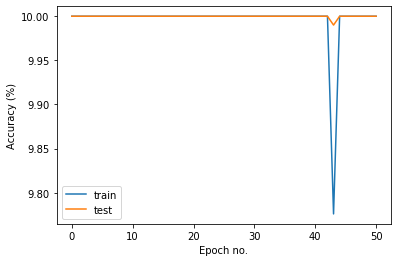

In [6]:

no_batch_norm = CNNModel().to(DEVICE)
nbn_history = train(no_batch_norm)
nbn_history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')

## b) Accuracy and convergence comparison to ConvBlock with Batch Norm

From these experiments, we can see that 2 is the optimal number of blocks with our CNN model without batch normalization. This was a little surprising to me, as I thought that increasing the depth of the model would directly correlate to better performance. However, we see that this really isn't the case because without batch normalization it will take many many more epocsh to converge.